In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (13, 7)

In [2]:
!pwd

/aiffel/aiffel/3. 인물사진을 만들어 보자


In [19]:
image_names

['profile.jpg', 'groups.jpg', 'soldier.webp', 'soldier2.jpeg', 'vogue.jpeg']

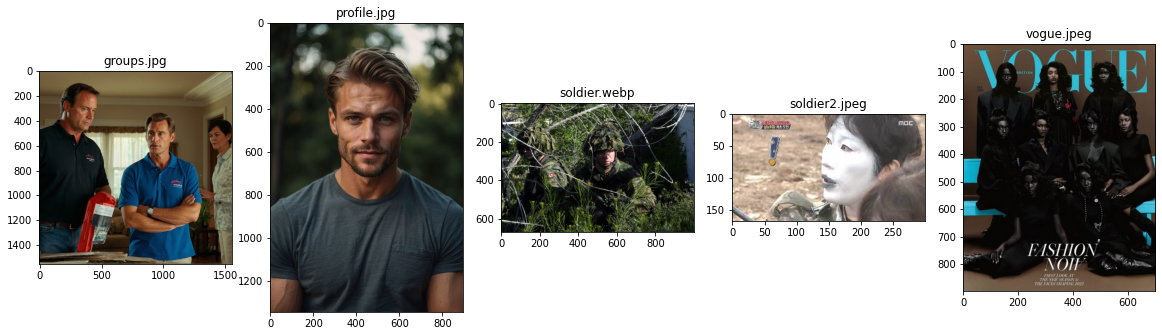

In [3]:
image_names = [
    "profile.jpg",
    "groups.jpg",    
    "soldier.webp",
    "soldier2.jpeg",
    "vogue.jpeg"
]

dir_path = '/aiffel/aiffel/3. 인물사진을 만들어 보자'  

def load_img():
    img_dict = {}
    for file in image_names:
        img_path = os.path.join(dir_path,file)
        img = cv2.imread(img_path)
        
        img_dict[img_path] = img
    
    return img_dict

def show_img(img_dict, row, col):
    
    fig, ax = plt.subplots(row,col,figsize = (20,20))
    img_name_list = list(img_dict.keys())
        
    for i in range(col*row):
        
        img_name = img_name_list[i]
        img_rgb = cv2.cvtColor(img_dict[img_name],cv2.COLOR_BGR2RGB)
        
        ax[i].imshow(img_rgb)
        ax[i].set_title(img_name.split("/")[-1])
        
    plt.show()

image_dict = load_img()
image_dict = dict(sorted(image_dict.items()))
show_img(image_dict, 1, len(image_names))

In [4]:
# 모델 선언
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

In [5]:
# 모델 load

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

# LABEL_NAMES = {i : LABEL_NAMES[i] for i in range(len(LABEL_NAMES))}


model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

In [6]:
# 인물 segment color 얻기

def get_colormap():
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3
    return colormap

person_idx = LABEL_NAMES.index('person')
print(get_colormap()[person_idx])

seg_color = (128, 128, 192)

[192 128 128]


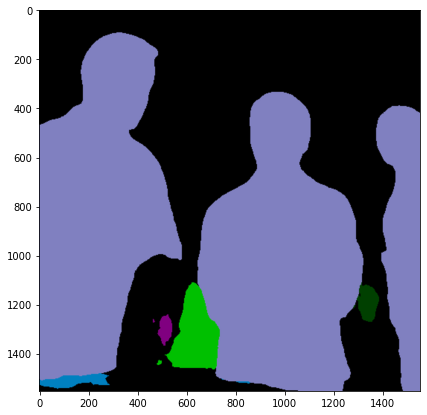

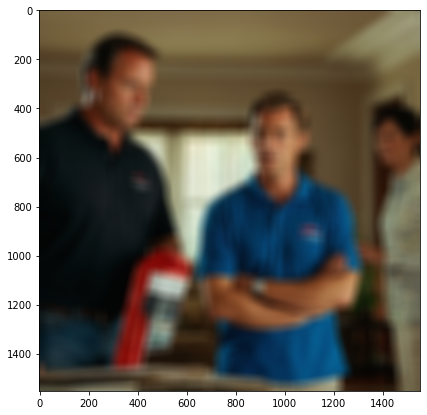

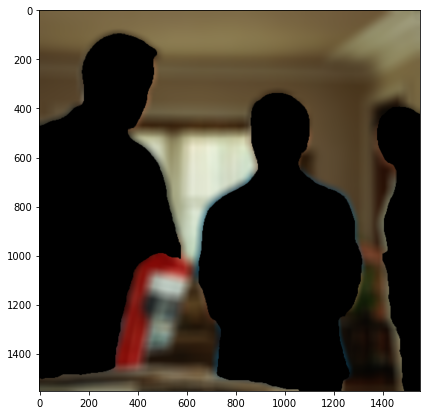

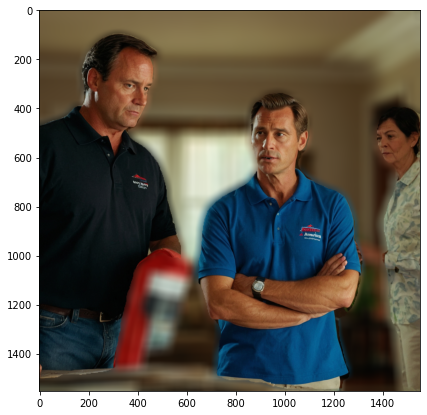

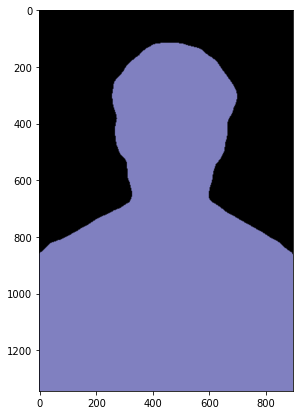

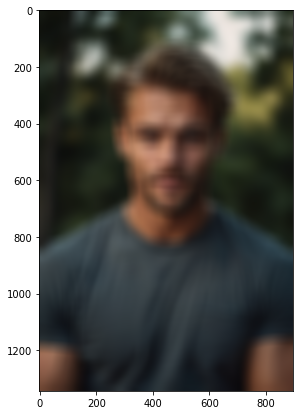

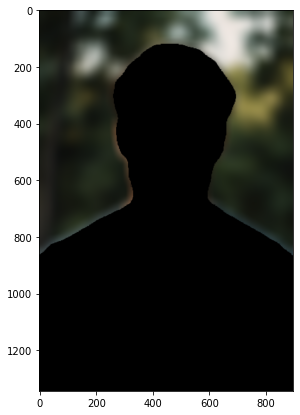

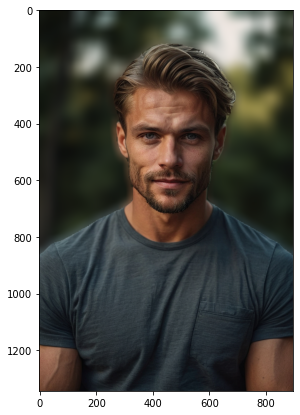

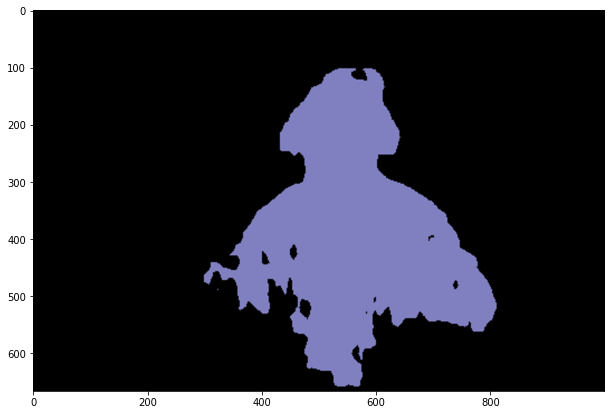

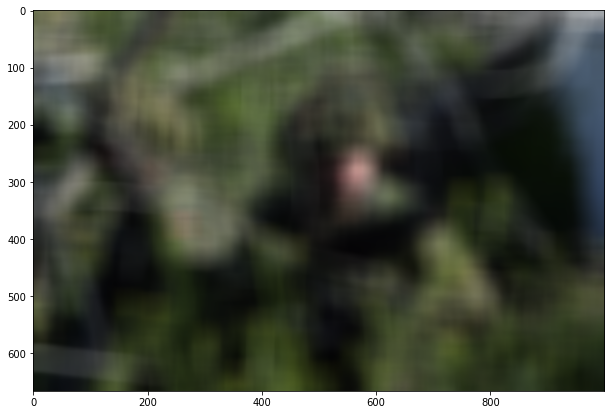

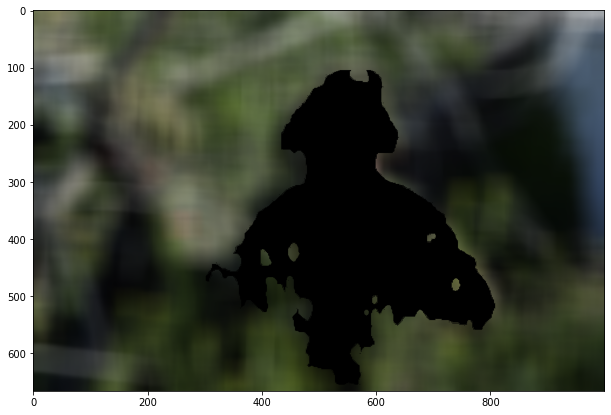

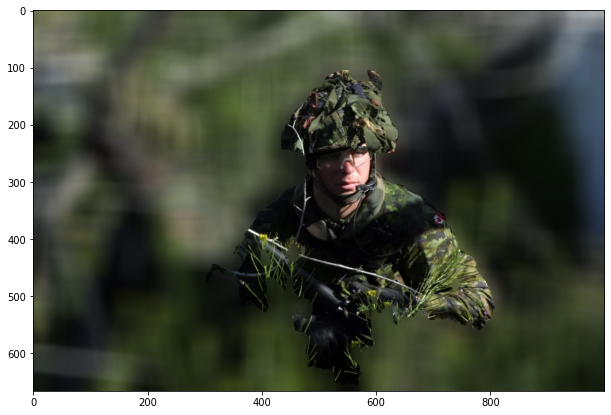

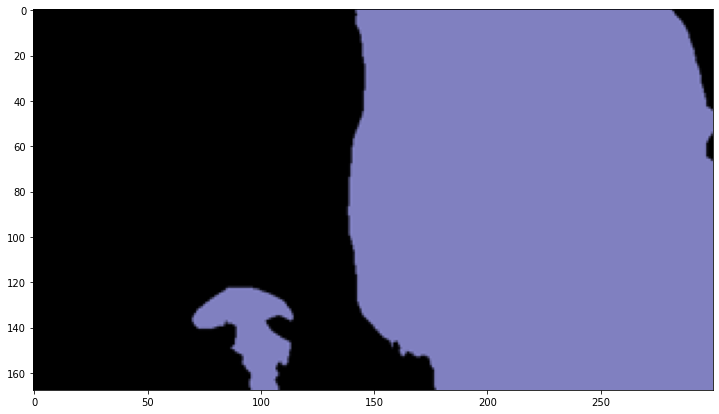

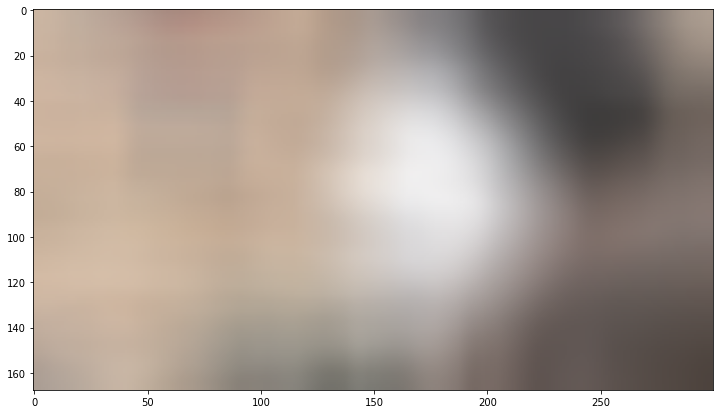

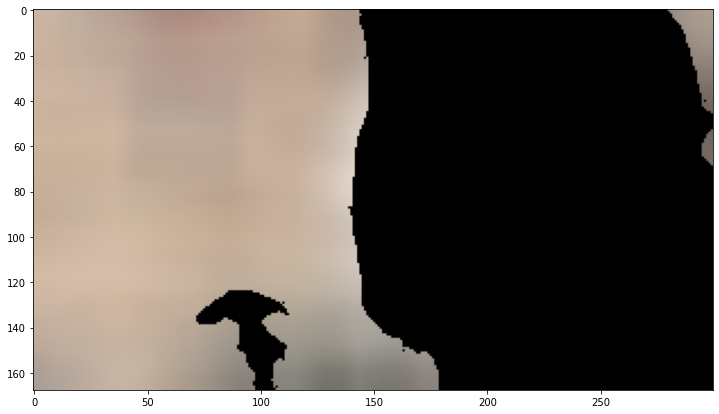

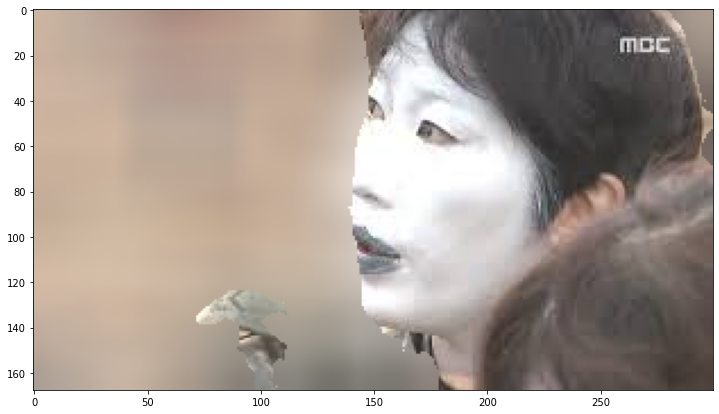

In [ ]:
# pascal segment
def get_pascal_segment(img_path):    
    _, output = model.segmentAsPascalvoc(img_path)
    plt.imshow(output)
    plt.show()
    return output

# 인물 segmentation mask
def get_image_mask(pascal_output):
    seg_map = np.all(pascal_output==seg_color, axis=-1) 
    img_mask = seg_map.astype(np.uint8) * 255 # Boolean -> (0 or 255)
    return img_mask


# 블러 이미지 생성
def get_blur(img_path):
    img = cv2.imread(img_path)
    img_blur = cv2.blur(img, (50, 50))
    plt.imshow(cv2.cvtColor(img_blur, cv2.COLOR_BGR2RGB))
    plt.show()
    return img_blur
 

def get_image_background_blur(img_mask_color, img_blur):
    # 배경이 0 사람이 255 -> 배경은 255 사람은 0
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_blur, img_bg_mask)
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()
    return img_bg_blur

def get_dof(img_path, img_mask_color, img_bg_blur):
    img = cv2.imread(img_path)
    img_concat = np.where(img_mask_color==255, img, img_bg_blur)

    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()



for path in image_dict.keys():
    pascal_output = get_pascal_segment(path)
    img_mask = get_image_mask(pascal_output)
    img_blur = get_blur(path)

    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_blur = get_image_background_blur(img_mask_color, img_blur)
    get_dof(path, img_mask_color, img_bg_blur)

생각 보다 위장 군인도 잘 찾아내고, 얼굴색이 어두운 인물도 잘 잡아내었다.
하지만, text가 함께 들어있거나, 인물의 전체 모습을 잘 잡아내지 못한걸 확인했다.

### **세그멘테이션의 한계:**  

Semantic segmentation의 부정확성은 여러 문제를 일으킬 수 있습니다. 보케(아웃포커싱) 효과는 정확한 심도 표현이 필요하지만, 이를 구현하는 semantic segmentation 모듈은 완벽한 정확도를 가지기 어렵습니다.
  
### 어떻게 해결할 것인가?

심도를 정확히 얻어내고 이를 기반으로 마스킹 영역을 설정하면 더 나은 결과를 얻을 수 있습니다. 이를 위해 `struct2depth` 같은 Unsupervised Learning of   Depth and Ego-Motion을 활용할 수 있습니다.


![](./depth.png)

<u>중앙에 있는 baseline 모델과 비교해서, 우측의 struct2depth는 depth prediction을 월등히 좋은 성능을 보여주고 있는 걸 확인할 수 있습니다.</u>

### 이외에도

- 스테레오 비전, ToF 등 3D 이미징 기술을 활용할 수 있습니다. 하드웨어 개발과 생산 비용을 절감하기 위해 소프트웨어 기술을 활용하는 노력도 많습니다. 구글의 struct2Depth가 대표적인 예가 되겠습니다.

- IR 카메라와 3D 심도 센싱 기술을 융합하는 것도 좋은 해결책이 될 수 있습니다. 예를 들어, Google Pixel 4의 uDepth 기술은 IR 카메라를 활용한 실시간 3D 심도 센싱을 구현합니다.